In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from astropy.io import fits
from grizli import model as griz_model
from scipy.interpolate import interp1d
from spec_tools import Get_Sensitivity
import pysynphot as S
import os
from glob import glob
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

In [254]:
class Single_spec(object):
    def __init__(self, beam, gal_id,min_wv = 8000, max_wv = 11500):
        BEAM = griz_model.BeamCutout(fits_file= beam)

        self.spec_2D = BEAM.grism.data['SCI']
        self.contam_2D = BEAM.contam
        self.clean_2D = BEAM.grism.data['SCI'] - BEAM.contam
        self.cutout = BEAM.beam.direct*(BEAM.beam.seg == gal_id)
        
        xspec, yspec, yerr = BEAM.beam.optimal_extract(BEAM.grism.data['SCI'], bin=0, ivar=BEAM.ivar) #data
        swv, sens = [BEAM.beam.lam, BEAM.beam.sensitivity / np.max(BEAM.beam.sensitivity)]
        isens = interp1d(swv, sens)(xspec)
        
        IDX= [U for U in range(len(xspec)) if min_wv < xspec[U] < max_wv]
        self.wv = xspec[IDX]
        self.fl = yspec[IDX] / isens[IDX]
        self.er = yerr[IDX] / isens[IDX]

class Stack_spec(object):
    def __init__(self, gal_id, g102_min = 8700, g102_max = 11300, g141_min = 11100, g141_max = 16450):
        self.gal_id = gal_id
        p_file = glob('../dataframes/phot/*{0}*'.format(gal_id))[0]
        self.phot_db = pd.read_pickle(p_file)
        
        self.g102_list = glob('../beams/*{0}*g102*'.format(gal_id))
        self.g141_list = glob('../beams/*{0}*g141*'.format(gal_id))
        self.g102_wv, self.g102_fl, self.g102_er = self.Stack_1d_beams(self.g102_list,g102_min,g102_max) 
        self.g141_wv, self.g141_fl, self.g141_er = self.Stack_1d_beams(self.g141_list,g141_min,g141_max) 
        
        spec141 = S.ArraySpectrum(self.g141_wv, self.g141_fl, fluxunits='flam')
        obs141 = S.Observation(spec141, S.ObsBandpass('wfc3,ir,f125w'), force='extrap')

        spec102 = S.ArraySpectrum(self.g102_wv, self.g102_fl, fluxunits='flam')
        obs102 = S.Observation(spec102,S.ObsBandpass('wfc3,ir,f098m'),force='extrap')
        
        C141 = self.phot_db.query('filter == "F125W"')['phot'].values[0] / obs141.effstim('flam')
        C102 = self.phot_db.query('filter == "F098M"')['phot'].values[0] / obs102.effstim('flam')
                
        self.g102_fl *= C102
        self.g102_er *= C102
        self.g141_fl *= C141
        self.g141_er *= C141
        
        self.Stack_g102_g141()
        
    def Stack_1d_beams(self, beam_list, min_wv, max_wv):
        spec = Single_spec(beam_list[0], self.gal_id, min_wv = min_wv, max_wv=max_wv)

        stack_wv = spec.wv[1:-1]

        flgrid = np.zeros([len(beam_list), len(stack_wv)])
        errgrid = np.zeros([len(beam_list), len(stack_wv)])

        # Get wv,fl,er for each spectra
        for i in range(len(beam_list)):
            spec = Single_spec(beam_list[i], self.gal_id, min_wv = min_wv, max_wv=max_wv)
            flgrid[i] = interp1d(spec.wv, spec.fl)(stack_wv)
            errgrid[i] = interp1d(spec.wv, spec.er)(stack_wv)
        ################

        flgrid = np.transpose(flgrid)
        errgrid = np.transpose(errgrid)
        weigrid = errgrid ** (-2)
        infmask = np.isinf(weigrid)
        weigrid[infmask] = 0
        ################

        stack, err = np.zeros([2, len(stack_wv)])
        for i in range(len(stack_wv)):
            stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
            err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
        ################


        stack_fl = np.array(stack)
        stack_er = np.array(err)

        return stack_wv, stack_fl, stack_er
    
    def Stack_g102_g141(self):
        
        bounds = [min(self.g141_wv),max(self.g102_wv)]
        del_g102 = self.g102_wv[1] - self.g102_wv[0]
        del_g141 = self.g141_wv[1] - self.g141_wv[0]
        del_mix = (del_g102 + del_g141) / 2
        mix_wv = np.arange(bounds[0],bounds[1],del_mix)    
        stack_wv = np.append(np.append(self.g102_wv[self.g102_wv < bounds[0]],mix_wv),self.g141_wv[self.g141_wv > bounds[1]])

        flgrid = np.zeros([2, len(stack_wv)])
        errgrid = np.zeros([2, len(stack_wv)])

        # Get wv,fl,er for each spectra
        for i in range(len(stack_wv)):
            if min(sp.g102_wv) <= stack_wv[i] <= max(self.g102_wv):
                flgrid[0][i] = interp1d(self.g102_wv, self.g102_fl)(stack_wv[i])
                errgrid[0][i] = interp1d(self.g102_wv, self.g102_er)(stack_wv[i])

            if min(sp.g141_wv) <= stack_wv[i] <= max(sp.g141_wv):
                flgrid[1][i] = interp1d(self.g141_wv, sp.g141_fl)(stack_wv[i])
                errgrid[1][i] = interp1d(self.g141_wv, sp.g141_er)(stack_wv[i])
        ################

        flgrid = np.transpose(flgrid)
        errgrid = np.transpose(errgrid)
        weigrid = errgrid ** (-2)
        infmask = np.isinf(weigrid)
        weigrid[infmask] = 0
        ################

        stack, err = np.zeros([2, len(stack_wv)])
        for i in range(len(stack_wv)):
            stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
            err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
        ################

        self.stack_wv = stack_wv
        self.stack_fl = np.array(stack)
        self.stack_er = np.array(err)

In [255]:
sp = Stack_spec(41520)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.opt

In [229]:
###DATA 
phot_db = pd.read_pickle('../dataframes/phot/gs_41520_phot.pkl')
Clam = 3E18 / phot_db['eff_wv'] **2 * 10**((-1.1)/2.5-29)


In [151]:
bp_v = S.ObsBandpass('wfc3,ir,f098m')


(0, 1.25e-18)

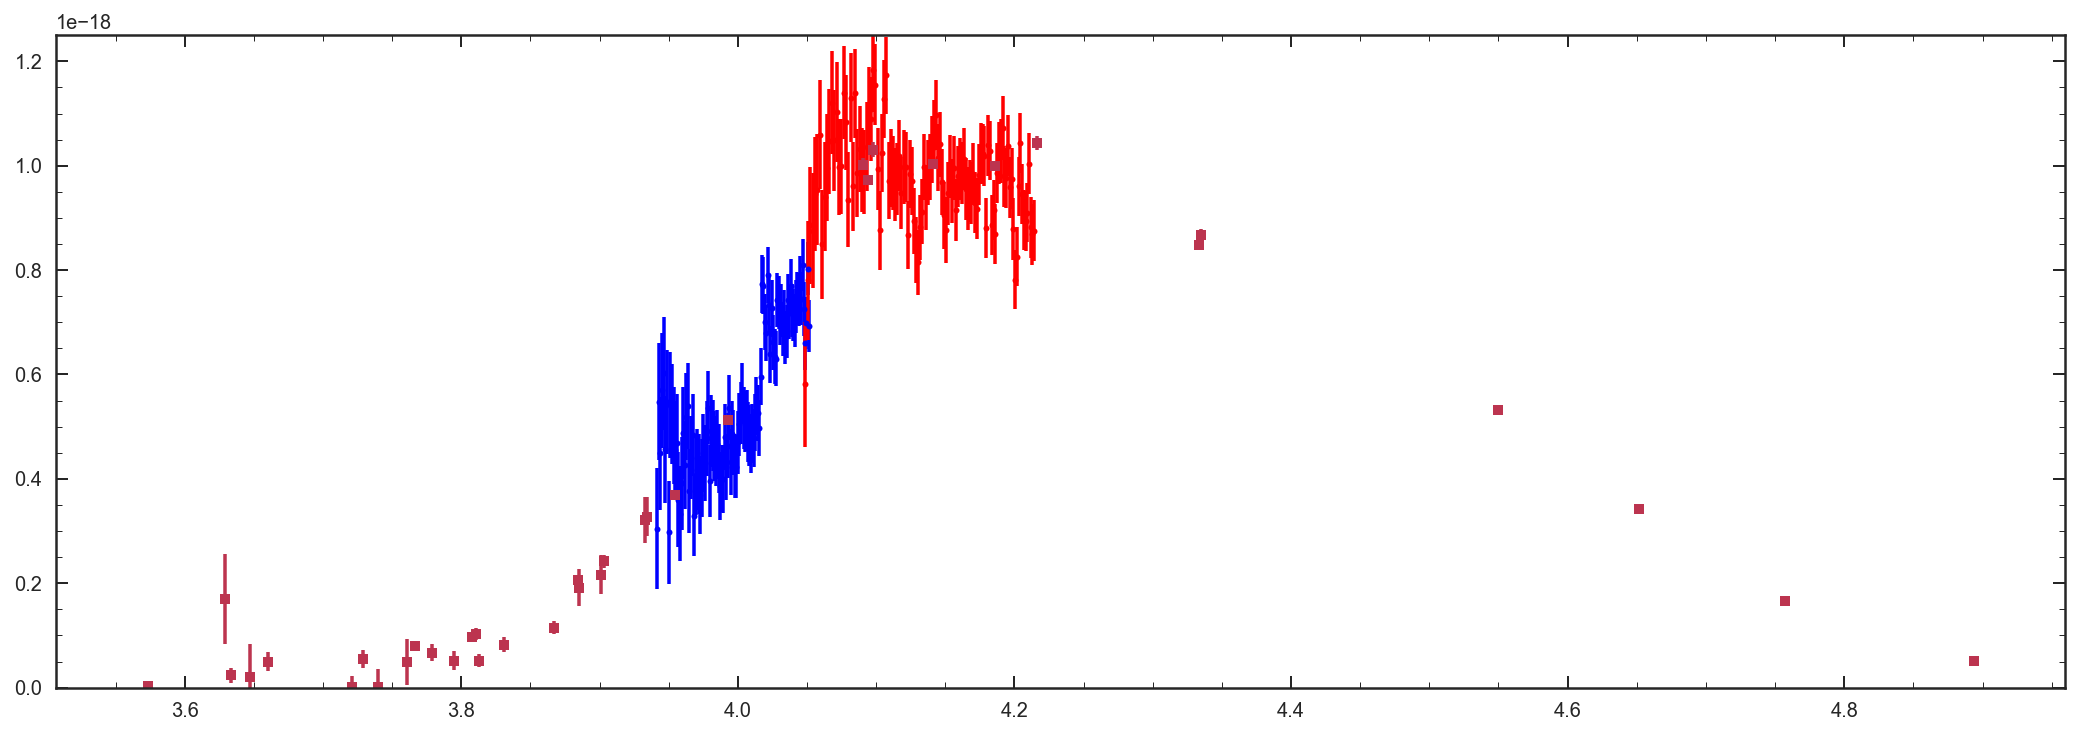

In [230]:
#2.603
plt.figure(figsize=[18,6])
plt.errorbar(np.log10(sp.g102_wv), sp.g102_fl, sp.g102_er, linestyle='None', marker='o', markersize=3, color='b')

plt.errorbar(np.log10(sp.g141_wv), sp.g141_fl, sp.g141_er, linestyle='None', marker='o', markersize=3, color='r')
plt.errorbar(np.log10(phot_db['eff_wv']),phot_db['phot'] ,phot_db['phot_err'],
             color='#BC344F',fmt='s',ms=5,label='Broad-Band Photometry', zorder=2)
# plt.axvline(3934.777,linestyle='--', alpha=.3)
# plt.axvline(3969.588,linestyle='--', alpha=.3)
# plt.axvline(4102.89,linestyle='--', alpha=.3)
# plt.axvline(4305.61,linestyle='--', alpha=.3)
# plt.axvline(4341.68,linestyle='--', alpha=.3)
# plt.axvline(4862.68,linestyle='--', alpha=.3)
# plt.axvline(5176.7,linestyle='--', alpha=.3)
# plt.axvline(5895.6,linestyle='--', alpha=.3)

# plt.axvspan(3910, 3980, color='k', alpha=.1)
# plt.axvspan(3980, 4030, color='k', alpha=.1)
# plt.axvspan(4080, 4120, color='k', alpha=.1)
# plt.axvspan(4250, 4380, color='k', alpha=.1)
# plt.axvspan(4810, 4910, color='k', alpha=.1)
# plt.axvspan(5120, 5240, color='k', alpha=.1)

# plt.axvspan(11000, 11350, color='k', alpha=.1)
# plt.xlim(5000,80000)
plt.ylim(0,1.25E-18)

# g102 and g141 stack test

<ErrorbarContainer object of 3 artists>

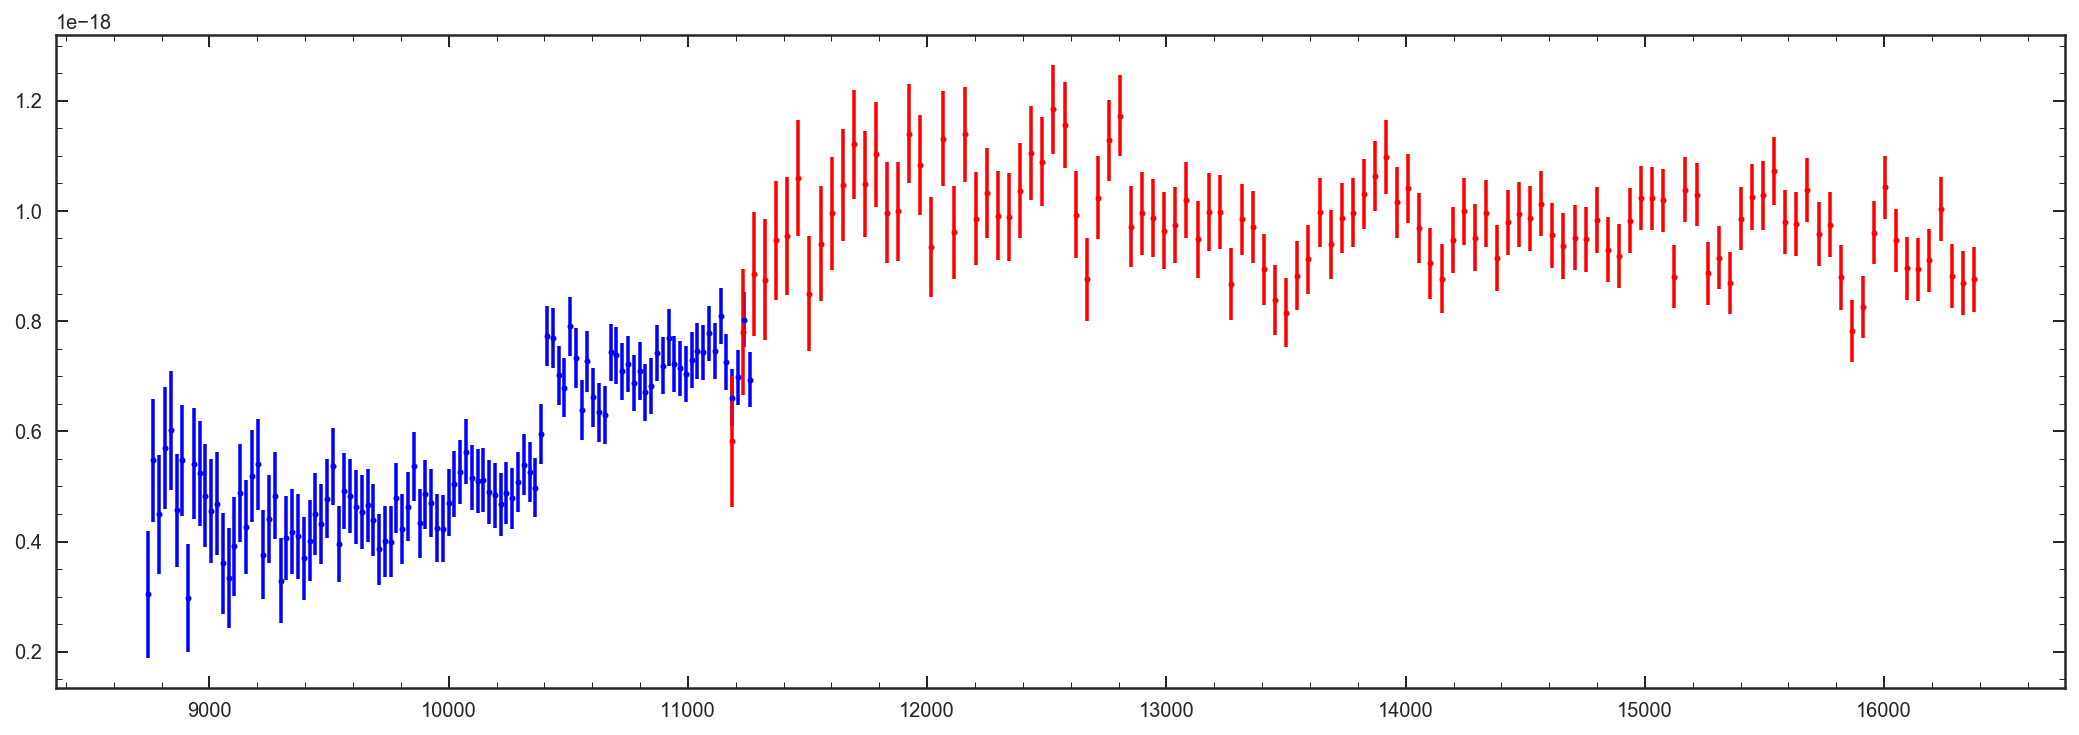

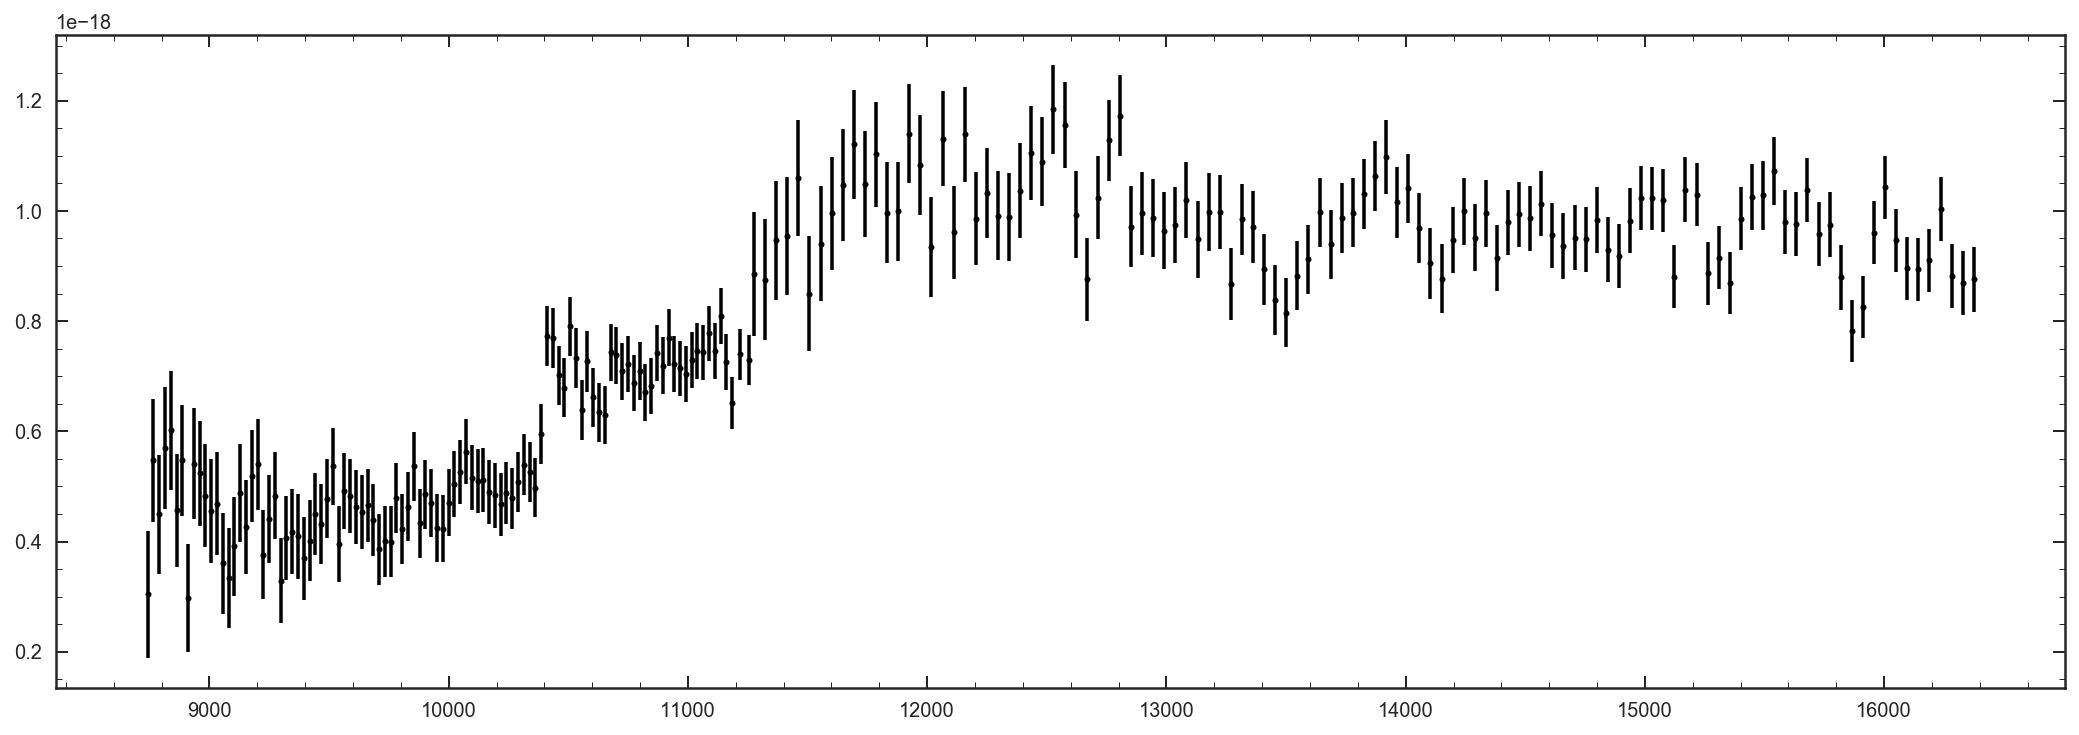

In [256]:
plt.figure(figsize=[18,6])
plt.errorbar(sp.g102_wv, sp.g102_fl, sp.g102_er, linestyle='None', marker='o', markersize=3, color='b')
plt.errorbar(sp.g141_wv, sp.g141_fl, sp.g141_er, linestyle='None', marker='o', markersize=3, color='r')

plt.figure(figsize=[18,6])
plt.errorbar(sp.stack_wv, sp.stack_fl, sp.stack_er, linestyle='None', marker='o', markersize=3, color='k')

In [238]:
bounds = [min(sp.g141_wv),max(sp.g102_wv)]
del_g102 = sp.g102_wv[1] - sp.g102_wv[0]
del_g141 = sp.g141_wv[1] - sp.g141_wv[0]
del_mix = (del_g102 + del_g141) / 2
mix_wv = np.arange(bounds[0],bounds[1],del_mix)

In [240]:
mix_wv

array([11183.74044821, 11219.01011362, 11254.27977903])

In [245]:
new_wv = np.append(np.append(sp.g102_wv[sp.g102_wv < bounds[0]],mix_wv),sp.g141_wv[sp.g141_wv > bounds[1]])

In [249]:
stack_wv = new_wv

flgrid = np.zeros([2, len(stack_wv)])
errgrid = np.zeros([2, len(stack_wv)])

# Get wv,fl,er for each spectra
for i in range(len(stack_wv)):
    if min(sp.g102_wv) <= stack_wv[i] <= max(sp.g102_wv):
        flgrid[0][i] = interp1d(sp.g102_wv, sp.g102_fl)(stack_wv[i])
        errgrid[0][i] = interp1d(sp.g102_wv, sp.g102_er)(stack_wv[i])
        
    if min(sp.g141_wv) <= stack_wv[i] <= max(sp.g141_wv):
        flgrid[1][i] = interp1d(sp.g141_wv, sp.g141_fl)(stack_wv[i])
        errgrid[1][i] = interp1d(sp.g141_wv, sp.g141_er)(stack_wv[i])
################

flgrid = np.transpose(flgrid)
errgrid = np.transpose(errgrid)
weigrid = errgrid ** (-2)
infmask = np.isinf(weigrid)
weigrid[infmask] = 0
################

stack, err = np.zeros([2, len(stack_wv)])
for i in range(len(stack_wv)):
    stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
    err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
################


stack_fl = np.array(stack)
stack_er = np.array(err)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power
